In [1]:
%load_ext autoreload
%autoreload 2
from mira.sources.amr.petrinet import *
from mira.modeling.amr.petrinet import *
from mira.metamodel.template_model import *
import sympy as sp
from mira.metamodel.utils import *
from mira.metamodel.templates import *
from mira.modeling import Model
from mira.modeling.ode import OdeModel, simulate_ode_model
import numpy as np

import matplotlib.pyplot as plt



In [ ]:
import sympy as sp
from mira.metamodel import *
from mira.sources.sympy_ode import template_model_from_sympy_odes
from mira.modeling.amr.petrinet import template_model_to_petrinet_json_file

# Define time variable
t = sp.symbols("t")

# Make S E P I H R model
# Stratify S, E, I, R
# Stratify S_human by l and h. Stratify I by 1 and 2 
# Define time-dependent variables
S, E, P, I, H, R = sp.symbols(
    "S E P I H R", cls=sp.Function
)

delta, eta, alpha, beta, pi, rho, nu, lambda_param, mu, sigma, omega, theta, k, tau1, tau2 = sp.symbols(
    "delta eta alpha beta pi rho nu lambda mu sigma omega theta k tau1 tau2"
)

N_h = S(t) + E(t) + P(t) + I(t) + H(t) + R_h(t)
lambda_h = beta * (alpha*P(t) + eta*I(t) + I(t)) / N + beta * I(t) / N

odes = [
    sp.Eq(S(t).diff(t), pi * (1 - rho) - nu * lambda_param * S(t) - mu * S(t)), 
    sp.Eq(E(t).diff(t), nu * S(t) * lambda_param + S(t) * lambda_param - (sigma + mu) * E(t)),
    sp.Eq(P(t).diff(t), sigma * E(t) - (omega + mu) * P(t)),
    sp.Eq(H(t).diff(t), k * I(t) + k2 * I2(t) - (delta + tau3 + mu) * H(t))
    
    
    
odes = [


    sp.Eq(I1(t).diff(t), omega * P(t) - (theta + k1 + tau1 + mu_h) * I1(t)),
    sp.Eq(I2(t).diff(t), theta * I1(t) - (k2 + delta_i + tau2 + mu_h) * I2(t)),
    sp.Eq(H(t).diff(t), k1 * I1(t) + k2 * I2(t) - (delta_h + tau3 + mu_h) * H(t)),
    sp.Eq(R_h(t).diff(t), tau1 * I1(t) + tau2 * I2(t) + tau3 * H(t) - mu_h * R_h(t)),
    sp.Eq(S_r(t).diff(t), pi_r - lambda_r * S_r(t) - mu_r * S_r(t)),
    sp.Eq(E_r(t).diff(t), lambda_r * S_r(t) - (sigma_r + mu_r) * E_r(t)),
    sp.Eq(I_r(t).diff(t), sigma_r * E_r(t) - (delta_r + tau_r + mu_r) * I_r(t)),
    sp.Eq(R_r(t).diff(t), tau_r * I_r(t) - mu_r * R_r(t)),
]

In [2]:
model = model_from_json_file(
    "notebooks/hackathon_2024.12/ModelA_base_petri.json"
)

In [29]:
for tem in model.templates:
    if hasattr(tem, "subject") and hasattr(tem, "outcome"):
        print(tem.type)
        print(f"{tem.subject.name}  :  {tem.outcome.name}")
        print(tem.rate_law)
        if hasattr(tem, "controllers"):
            for c in tem.controllers:
                print(c)
                print()
        print()
    elif hasattr(tem, "subject"):
        print(tem.subject.name)
        print()
    else:
        print(tem.outcome.name)
        print()

S_l

GroupedControlledConversion
S_l  :  E_h
S_l*nu*(I_r*beta_rh/(E_r + I_r + R_r + S_r) + beta_hh*(I1*eta + I2 + P*alpha)/(E_h + H + I1 + I2 + P + R_h + S_h + S_l))
name='E_r' display_name='E_r' description=None identifiers={'apollosv': '00000154'} context={'species': 'ncbitaxon:9989'} units=None

name='P' display_name='P' description=None identifiers={'ido': '0000511'} context={'stage': 'predromal', 'species': 'ncbitaxon:9606'} units=None

name='E_h' display_name='E_h' description=None identifiers={'apollosv': '00000154'} context={'species': 'ncbitaxon:9606'} units=None

name='S_h' display_name='S_h' description=None identifiers={'ido': '0000514'} context={'severity': 'high', 'species': 'ncbitaxon:9606'} units=None

name='I_r' display_name='I_r' description=None identifiers={'ido': '0000511'} context={'species': 'ncbitaxon:9989'} units=None

name='I2' display_name='I2' description=None identifiers={'ido': '0000511'} context={'stage': 'severe', 'species': 'ncbitaxon:9606'} units=None


In [19]:
S_p = Concept(name="S_p")
E_p = Concept(name="E_p")
I_p = Concept(name="I_p")
R_p = Concept(name="R_p")
lambda_p = safe_parse_expr("beta_pp*I_p/(S_p+E_p+I_p+R_p)")

# t1 to t8 templates are the the exact same as the rodent-specific templates with pet-specific parameters
t1 = NaturalProduction(outcome=S_p, rate_law=safe_parse_expr("pi_p"))
t2 = NaturalDegradation(subject=S_p, rate_law=safe_parse_expr("mu_p*S_p"))
t3 = GroupedControlledConversion(
    subject=S_p,
    outcome=E_p,
    controllers=[E_p, R_p, I_p],
    rate_law=lambda_p * safe_parse_expr("S_p"),
)

t4 = NaturalDegradation(
    subject=E_p, rate_law=safe_parse_expr("E_p*(mu_p + sigma_p)")
)
t5 = ControlledProduction(
    outcome=I_p, rate_law=safe_parse_expr("E_p*sigma_p"), controller=I_p
)
t6 = NaturalDegradation(
    subject=I_p, rate_law=safe_parse_expr("I_r*(delta_p+mu_p+tau_p)")
)
t7 = NaturalDegradation(subject=R_p, rate_law=safe_parse_expr("R_p*mu_p"))
t8 = ControlledProduction(
    outcome=R_p, rate_law=safe_parse_expr("I_p*tau_p"), controller=R_p
)


# t9 to t10 represent templates that contain pets infecting high and low-risk susceptible humans 
t9 = NaturalConversion(
    subject=I_p,
    outcome=model.get_concept("S_h"),
    rate_law=safe_parse_expr(
        "beta_ph * I_p/(S_p + E_p + I_p + R_p ) * (rho*S_h) + (rho*pi_h)"
    ),
)
t10 = NaturalConversion(
    subject=I_p,
    outcome=model.get_concept("S_l"),
    rate_law=safe_parse_expr(
        "beta_ph * I_p/(S_p+ E_p + I_p + R_p ) * ((1-rho) * S_l) + ((1-rho)*pi_h)"
    ),
)

# t11 represent rodents infecting pets 
t11 = NaturalConversion(
    subject=model.get_concept("I_r"),
    outcome=S_p,
    rate_law=safe_parse_expr("beta_rp * I_r/(S_r+E_r+I_r+R_r) * S_p * pi_p"),
)

# pet recruitment rate 
# Not sure if to use integer like pi_h (2,500) in paper or normalized value like pi_r (.5) in paper
# Opted to do float like with rats and set it lower than .5 as I assume that rats proliferate at a faster rate than pets 
model.add_parameter("pi_p", value=0.25)

# pet natural death rate 
# Decided to set it one magnitude lower than natural death rate for rodents
model.add_parameter("mu_p", value=0.0003)

# pet progression rate 
# Set it on the same magnitude as humans but lower than humans as humans are exposed more to the disease in general
# However, set it on the same magnitude as pets are always in close proximity to humans 
model.add_parameter("sigma_p", value=0.015)

# pet mpox induced death rate 
# Set it between human and rodent mpox induced death rate as pets usually recieve better health-care than rodents 
# but worse health-care than humans
model.add_parameter("delta_p", value=0.01)

# pet recovery rate 
# Not sure if I was reading this correctly but I'm suprised to see that the recovery rate for rodents (tau_r = 0.08) is 
# higher than the human recovery rate. And the recovery rate from mildly infected to recovered (tau_1 = 0.048) is lower than the recovery rate from 
# severely infected to recovered (tau_2 = 0.05). 
model.add_parameter("tau_p", value=0.070)

# infection rates between pets must be lower than infection rate between rodents (beta_rr = 0.025)
model.add_parameter("beta_pp", value=0.015)
# infection rates between pets and humans must be higher than infection rate between rodent and humans (beta_rh = .3045) 
model.add_parameter("beta_ph", value=0.4045)
# infection rate between rodents and pets. No requirement for this but since beta_rh = 0.3045, and humans are more likely to come in 
# contact with rodents, I set beta_rp less than beta_rh
model.add_parameter("beta_rp", value=0.2045)

# Not sure what values to use for pets for initials, just assumed it'd be lower than rats
# templates_to_add = [t1, t2, t3, t4, t5, t6, t7, t8, t9, t10, t11]
templates_to_add = [t1, t2, t3, t4, t5, t6, t7, t8]
model.templates.extend(templates_to_add)
initials = {
    'S_p': Initial(concept=Concept(name='S_p'), expression=SympyExprStr(sp.Float(5e4))),
    'E_p': Initial(concept=Concept(name='E_p'), expression=SympyExprStr(sp.Float(500))),
    'I_p': Initial(concept=Concept(name='I_p'), expression=SympyExprStr(sp.Float(10))),
    'R_p': Initial(concept=Concept(name='R_p'), expression=SympyExprStr(sp.Float(1))),
}
model.initials.update(initials)



In [20]:
om = OdeModel(Model(model), initialized=True)



In [21]:
om.get_interpretable_kinetics()

Matrix([
[Derivative(S_l, t), =,                                                               I_p*S_l*beta_ph*(1 - rho)/(E_p + I_p + R_p + S_p) - S_l*mu_h - S_l*nu*(I_r*beta_rh/(E_r + I_r + R_r + S_r) + beta_hh*(I1*eta + I2 + P*alpha)/(E_h + H + I1 + I2 + P + R_h + S_h + S_l)) + 2*pi_h*(1 - rho)],
[Derivative(E_r, t), =,                                                                                                                                                                                                          -E_r*(mu_r + sigma_r) + I_r*S_r*beta_rr/(E_r + I_r + R_r + S_r)],
[  Derivative(P, t), =,                                                                                                                                                                                                                                           E_h*sigma_h - P*(mu_h + omega)],
[Derivative(E_h, t), =, -E_h*(mu_h + sigma_h) + S_h*(I_r*beta_rh/(E_r + I_r + R_r + S_r) + beta_hh*(I1*eta + I2 + P*al

In [22]:
nweeks = 35
times = np.linspace(0, nweeks*7, nweeks)
res = simulate_ode_model(om, times, with_observables=True)

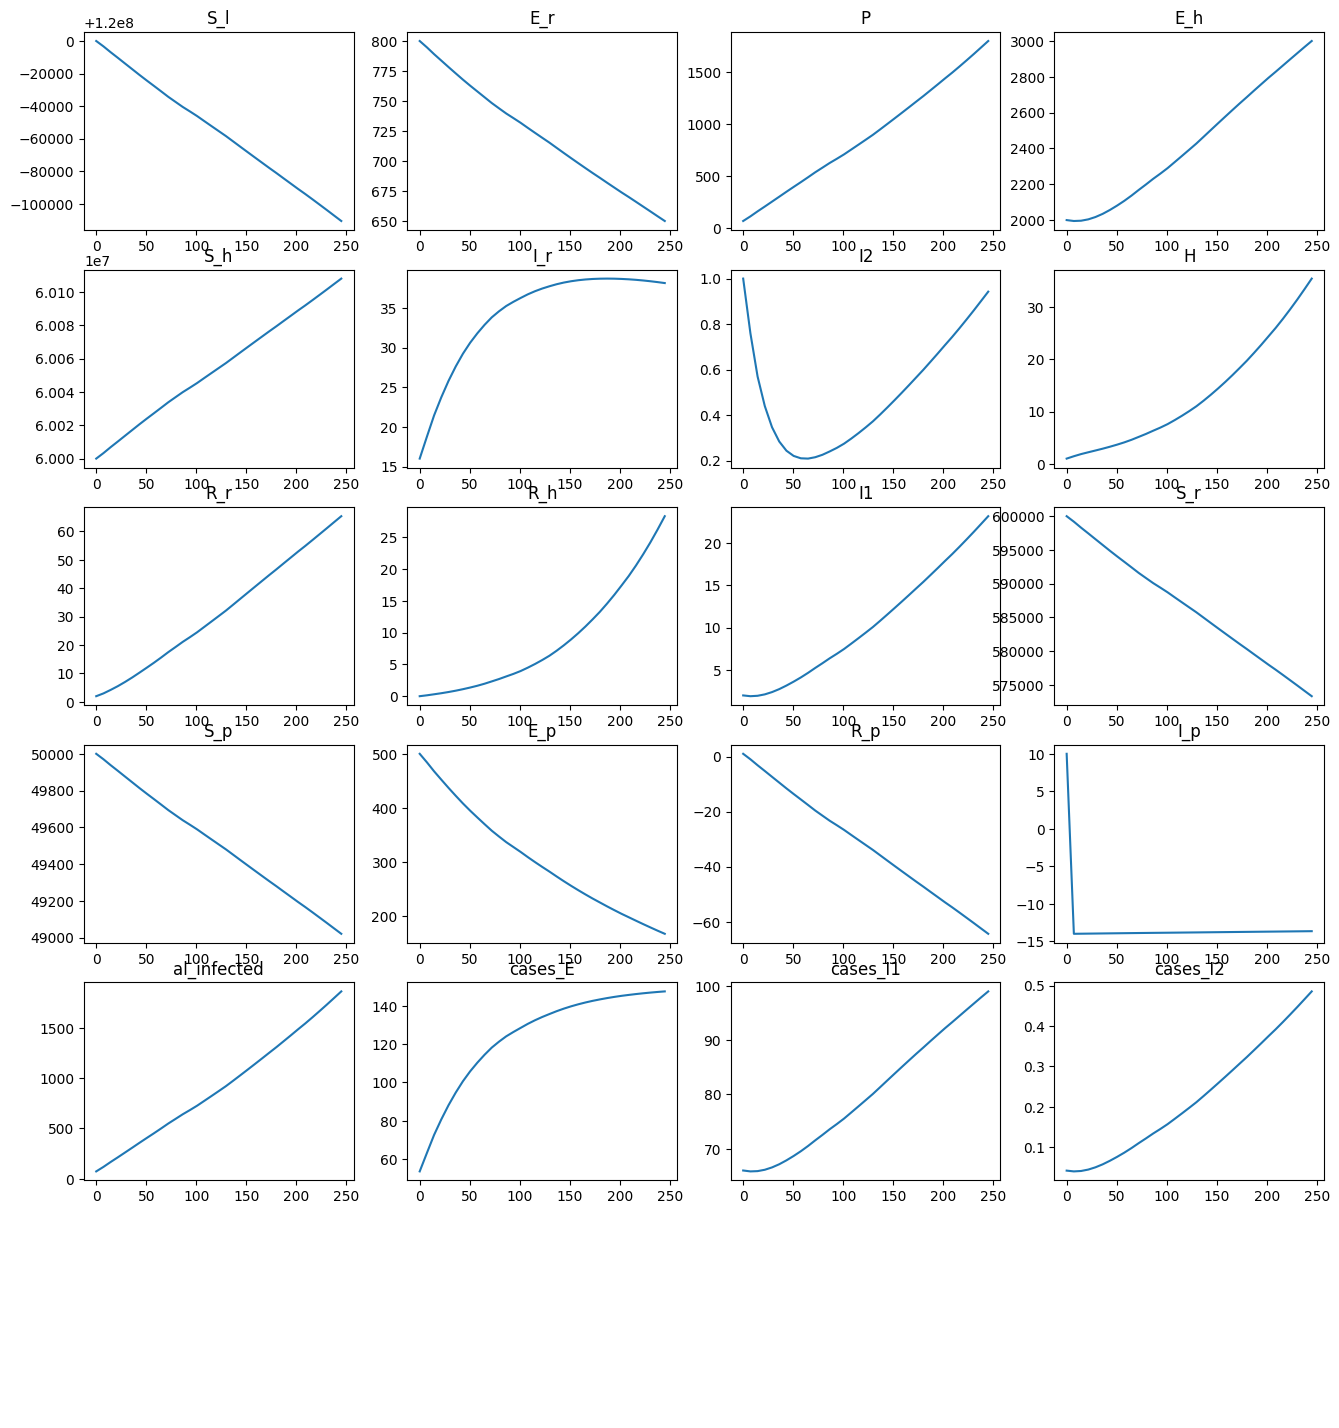

In [23]:
om.plot_simulation_results(times, res)